# Modeling

In [1]:
#INSTALLING DEPENDENCIES
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from keras import regularizers

## Loading Preprocessed Data 

In [2]:
# file for data from 2018-2021 : Kelmarsh_turbine1(2018-2021).csv
# file for 2020 data Kelmarsh_turbine1-2020.csv

#reading the clean data
PreprocessedDataTurbine1 = pd.read_csv("Kelmarsh_turbine1(2018-2021).csv", sep=',')
PreprocessedDataTurbine1 = PreprocessedDataTurbine1.drop('Unnamed: 0', axis=1)

PreprocessedDataTurbine1.head()

,Wind speed (m/s),Long Term Wind (m/s),Wind speed Sensor 1 (m/s),Wind speed Sensor 2 (m/s),Wind direction (°),Nacelle position (°),Vane position 1+2 (°),Power (kW),Turbine Power setpoint (kW),Reactive power (kvar),...,Blade angle (pitch position) C (°),Yaw bearing angle (°),Gear oil inlet pressure (bar),Gear oil pump pressure (bar),Grid frequency (Hz),Apparent power (kVA),Drive train acceleration (mm/ss),Tower Acceleration X (mm/ss),Tower Acceleration y (mm/ss),anomaly
0,0.742150,-0.609653,0.658625,0.746686,1.588854,1.62371,-0.260758,0.712101,1.021277,-0.736459,...,-0.376718,1.623709,1.114850,0.812539,-0.089257,0.709760,5.487802,0.025632,0.445277,1
1,0.567030,-0.609653,0.513932,0.612426,1.561509,1.62371,-0.311974,0.609483,0.917348,-0.650119,...,-0.376718,1.623709,1.264111,0.955602,-0.052797,0.612785,6.339041,0.002650,0.307569,1
2,0.617562,-0.609653,0.580067,0.627677,1.555763,1.62371,-0.334879,0.700478,1.173613,-0.887011,...,-0.376718,1.623709,0.545394,0.314733,0.107740,0.712037,6.383784,-0.234531,0.052997,1
3,0.607886,-0.609653,0.570906,0.614425,1.549362,1.62371,-0.496544,0.643069,0.978726,-0.718919,...,-0.376718,1.623709,1.824157,1.404832,-0.140324,0.644570,6.049186,-0.202035,0.906125,1
4,0.576726,-0.609653,0.531557,0.519676,1.555541,1.62371,-0.492387,0.451087,0.812603,-0.592508,...,-0.376718,1.623709,0.764606,0.479379,-0.184053,0.456094,6.012873,-0.248266,0.675658,1


In [3]:
PreprocessedDataTurbine1.shape

(166905, 49)

## Splitting the data to train and test data 

### Time Series Split (For LSTM-AE model)

In [4]:
# Assume your data is in a pandas DataFrame named 'df' with a datetime index
split_point = int(.85 * PreprocessedDataTurbine1.shape[0])
train_data = PreprocessedDataTurbine1.loc[PreprocessedDataTurbine1.index < split_point]
test_data = PreprocessedDataTurbine1.loc[PreprocessedDataTurbine1.index >= split_point]

# Split the data into X (features) and y (labels/target)
X_train, y_train = train_data.drop('anomaly', axis=1), train_data['anomaly']
X_test, y_test = test_data.drop('anomaly', axis=1), test_data['anomaly']

# get the indices of the normal points in y_train
normal_idx = y_train[y_train == 0].index
anomaly_idx = y_train[y_train == 1].index

# select only the rows with normal points from X_train to train our unsupervised model
X_train_normal = X_train.loc[normal_idx]
X_train_anomalies = X_train.loc[anomaly_idx]
X_train_normal.shape

train_anomalies = np.count_nonzero(y_train == 1)
test_anomalies = np.count_nonzero(y_test == 1)
print("Size of training data:", y_train.shape)
print("Number of anomalies in training data:", train_anomalies)
print("Size of test data:", y_test.shape)
print("Number of anomalies in test data:", test_anomalies)

Size of training data: (141869,)
Number of anomalies in training data: 43339
Size of test data: (25036,)
Number of anomalies in test data: 2445


### Splitting Row Data 

In [5]:
Rowdata=PreprocessedDataTurbine1

X, y = Rowdata.drop('anomaly', axis=1), Rowdata['anomaly']

# Split the data into training and testing sets
Row_X_train, Row_X_test, Row_y_train, Row_y_test = train_test_split(X, y, test_size=0.3)

Row_train_anomalies = np.count_nonzero(Row_y_train == 1)
Row_test_anomalies = np.count_nonzero(Row_y_test == 1)

print("Size of training data:", Row_y_train.shape)
print("Number of anomalies in training data:", Row_train_anomalies)
print("Size of test data:", Row_y_test.shape)
print("Number of anomalies in test data:", Row_test_anomalies)

Size of training data: (116833,)
Number of anomalies in training data: 32018
Size of test data: (50072,)
Number of anomalies in test data: 13766


## Models

### LSTM-AE 

In [20]:
 # reshape inputs for LSTM [samples, timesteps, features]
X_Train = X_train_normal.values
X_Test = X_test.values
n_samples_train = X_Train.shape[0]
n_features = X_Train.shape[1]
n_timesteps = 1
X_Train = X_Train.reshape(n_samples_train, n_timesteps, n_features)
print("Training data shape:", X_Train.shape)
n_samples_test = X_Test.shape[0]
X_Test = X_Test.reshape(n_samples_test, n_timesteps, n_features)
print("Test data shape:", X_Test.shape)

Training data shape: (98530, 1, 48)
Test data shape: (25036, 1, 48)


In [154]:
lstmunits=64
# define the autoencoder network model
def lstm_autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(lstmunits, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(lstmunits, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [155]:
# create the autoencoder model
lstmae_model = lstm_autoencoder_model(X_Train)
lstmae_model.compile(optimizer='adam', loss='mae')
lstmae_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 48)]           0         
                                                                 
 lstm_44 (LSTM)              (None, 1, 64)             28928     
                                                                 
 lstm_45 (LSTM)              (None, 4)                 1104      
                                                                 
 repeat_vector_11 (RepeatVec  (None, 1, 4)             0         
 tor)                                                            
                                                                 
 lstm_46 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_47 (LSTM)              (None, 1, 64)             17664     
                                                          

In [247]:
# fit the model to the data
nb_epochs = 70
batch_size = 256
lstmae_history = lstmae_model.fit(X_Train, X_Train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.15).history

Epoch 1/70
328/328 [==============================] - 2s 7ms/step - loss: 0.1491 - val_loss: 0.1517
Epoch 2/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1491 - val_loss: 0.1511
Epoch 3/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1491 - val_loss: 0.1526
Epoch 4/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1490 - val_loss: 0.1516
Epoch 5/70
328/328 [==============================] - 2s 7ms/step - loss: 0.1490 - val_loss: 0.1519
Epoch 6/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1491 - val_loss: 0.1518
Epoch 7/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1490 - val_loss: 0.1522
Epoch 8/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1490 - val_loss: 0.1519
Epoch 9/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1490 - val_loss: 0.1519
Epoch 10/70
328/328 [==============================] - 2s 6ms/step - loss: 0.1490 - val_loss: 0.1515

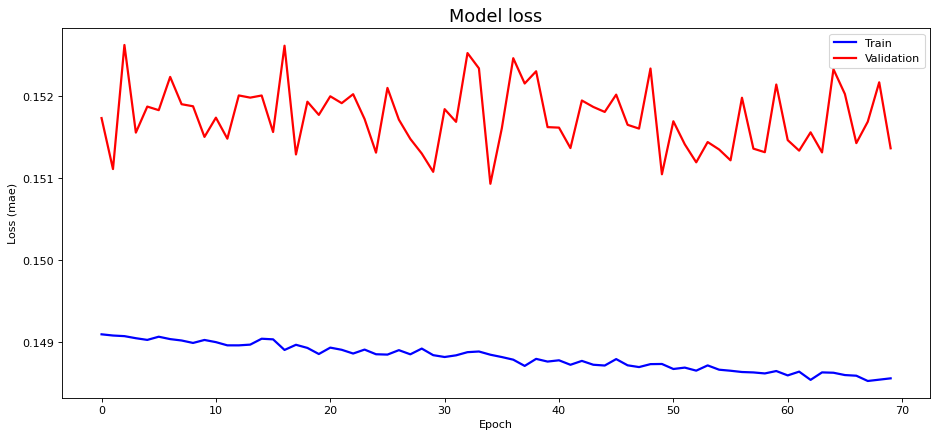

In [248]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(lstmae_history['loss'], 'b', label='Train', linewidth=2)
ax.plot(lstmae_history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

3080/3080 [==============================] - 9s 3ms/step


(0.0, 0.5)

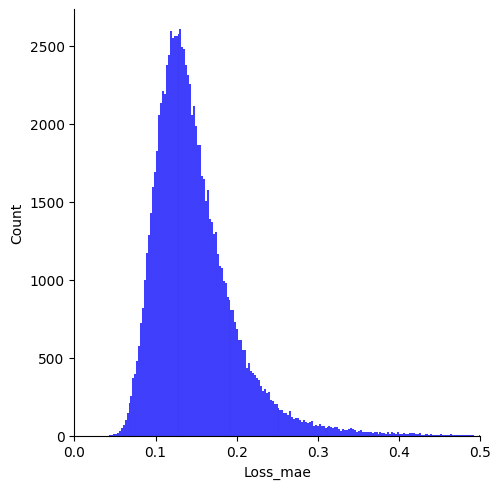

In [249]:
# plot the loss distribution of the training set
lstmae_X_pred = lstmae_model.predict(X_Train)
lstmae_X_pred = lstmae_X_pred.reshape(lstmae_X_pred.shape[0], lstmae_X_pred.shape[2])
lstmae_X_pred = pd.DataFrame(lstmae_X_pred, columns=X_train_normal.columns)
lstmae_X_pred.index = X_train_normal.index

lstmae_scored = pd.DataFrame(index=X_train_normal.index)
Xtrain = X_Train.reshape(X_Train.shape[0], X_Train.shape[2])
lstmae_scored['Loss_mae'] = np.mean(np.abs(lstmae_X_pred-Xtrain), axis = 1)


sns.displot(lstmae_scored['Loss_mae'], color = 'blue');
plt.xlim([0.0,0.5])

In [254]:
# calculate the loss on the test set
lstmae_x_pred = lstmae_model.predict(X_Test)
lstmae_X_pred = lstmae_x_pred
lstmae_X_pred = lstmae_X_pred.reshape(lstmae_X_pred.shape[0], lstmae_X_pred.shape[2])
lstmae_X_pred = pd.DataFrame(lstmae_X_pred, columns=X_test.columns)
lstmae_X_pred.index = X_test.index
lstmae_scored = pd.DataFrame(index=X_test.index)
lstmae_Xtest = X_Test.reshape(X_Test.shape[0], X_Test.shape[2])
lstmae_scored['Loss_mae'] = np.mean(np.abs(lstmae_X_pred-lstmae_Xtest), axis = 1)
lstmae_scored['Threshold'] = 0.27
lstmae_scored['Anomaly'] = lstmae_scored['Loss_mae'] > lstmae_scored['Threshold']
lstmae_scored.head()

print(lstmae_scored.loc[lstmae_scored['Anomaly']==True].shape)
print(y_test.sum())


783/783 [==============================] - 1s 2ms/step
(1330, 3)
2445


<Axes: >

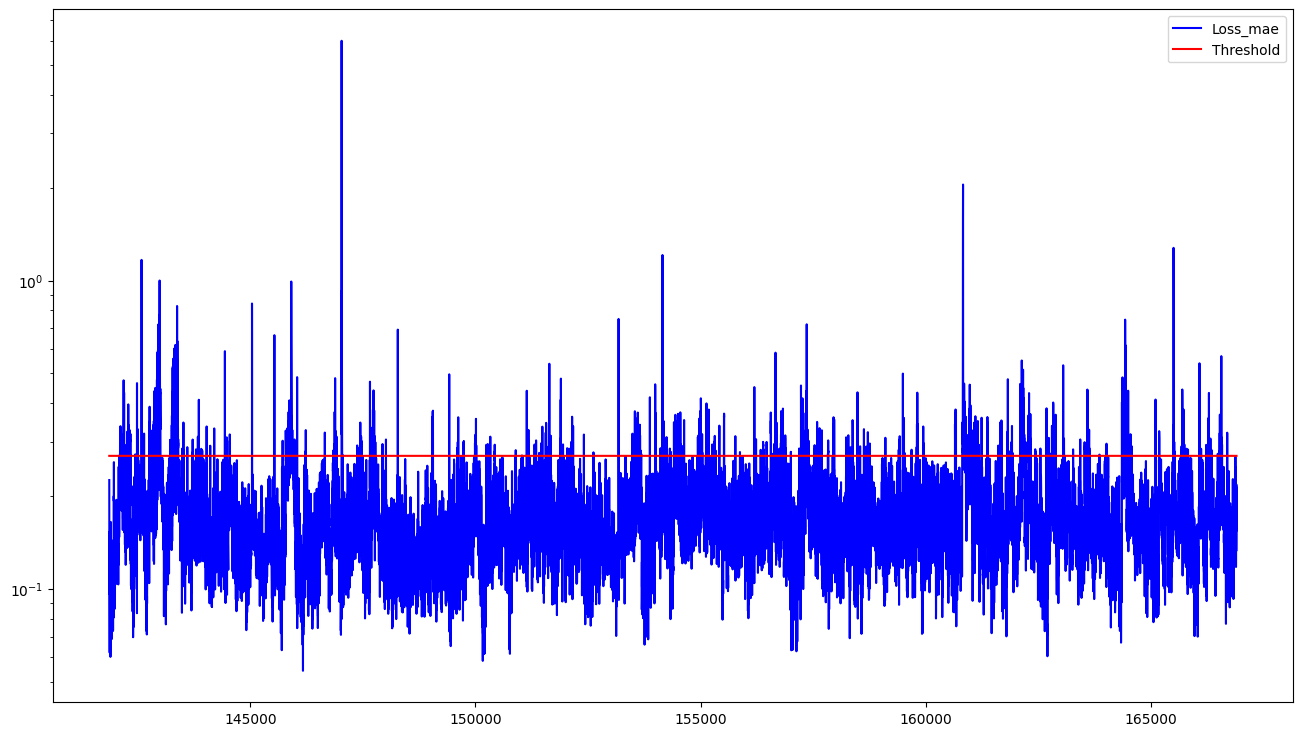

In [255]:
# plot bearing failure time plot
lstmae_scored.plot(logy=True, figsize=(16,9), color=['blue','red'])

In [256]:
print(lstmae_scored.loc[lstmae_scored['Loss_mae'] > lstmae_scored['Threshold']].shape)

lstmae_ypred=lstmae_scored['Anomaly']

# y_test and ypred are the true and predicted labels, respectively
report = classification_report(y_test, lstmae_ypred)

print(report)

(1330, 3)
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     22591
           1       0.15      0.08      0.11      2445

    accuracy                           0.87     25036
   macro avg       0.53      0.52      0.52     25036
weighted avg       0.83      0.87      0.85     25036



In [257]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the metrics
mae = np.mean(np.abs(lstmae_X_pred - X_test), axis=1)
rmse = np.sqrt(mean_squared_error(X_Test.reshape(-1), lstmae_x_pred.reshape(-1)))
train_loss = lstmae_history['loss'][-1]
val_loss = lstmae_history['val_loss'][-1]

print("MAE: ", np.mean(mae))
print("RMSE: ", rmse)
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

MAE:  0.1711966409674165
RMSE:  0.3837926601069049
Training loss:  0.14855721592903137
Validation loss:  0.15136706829071045


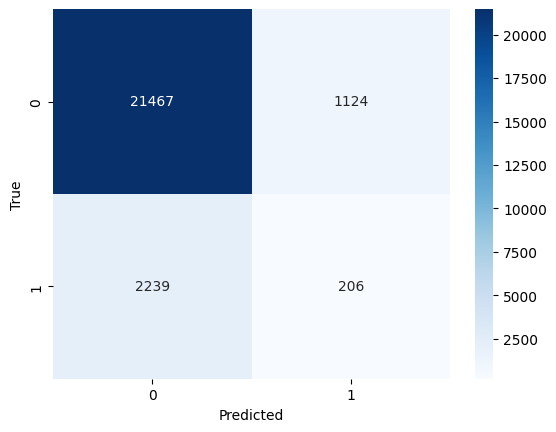

<Figure size 640x480 with 0 Axes>

In [259]:
# Compute the confusion matrix
lstmae_cm = confusion_matrix(y_test, lstmae_ypred)

# Plot the confusion matrix
sns.heatmap(lstmae_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save the plot as an image
plt.savefig('confusion_matrix.png')

### CNN 

In [6]:
# Split the data into X (features) and y (labels/target)
#cnn_X_train, cnn_y_train = train_data.drop('anomaly', axis=1), train_data['anomaly']
#cnn_X_test, cnn_y_test = test_data.drop('anomaly', axis=1), test_data['anomaly']

cnn_X_train = Row_X_train
cnn_y_train = Row_y_train
cnn_X_test = Row_X_test
cnn_y_test = Row_y_test

# Reshape the data for CNN input
cnn_X_train = np.reshape(cnn_X_train.values, (cnn_X_train.shape[0], cnn_X_train.shape[1], 1))
cnn_X_test = np.reshape(cnn_X_test.values, (cnn_X_test.shape[0], cnn_X_test.shape[1], 1))


In [7]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(cnn_X_train.shape[1], cnn_X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=1024, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=1, activation='sigmoid'))

In [8]:
# Compile the model with binary cross-entropy loss and Adam optimizer
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

nb_epochs = 90
batch_size = 64

# Train the CNN model on the training data
history = cnn_model.fit(cnn_X_train, cnn_y_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.15)

C:\Users\dell\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/90
1552/1552 [==============================] - 19s 12ms/step - loss: 0.5210 - accuracy: 0.7415 - val_loss: 0.4874 - val_accuracy: 0.7618
Epoch 2/90
1552/1552 [==============================] - 17s 11ms/step - loss: 0.4697 - accuracy: 0.7751 - val_loss: 0.4518 - val_accuracy: 0.7861
Epoch 3/90
1552/1552 [==============================] - 17s 11ms/step - loss: 0.4361 - accuracy: 0.7988 - val_loss: 0.4283 - val_accuracy: 0.8022
Epoch 4/90
1552/1552 [==============================] - 16s 11ms/step - loss: 0.4088 - accuracy: 0.8150 - val_loss: 0.3928 - val_accuracy: 0.8224
Epoch 5/90
1552/1552 [==============================] - 15s 9ms/step - loss: 0.3869 - accuracy: 0.8280 - val_loss: 0.3747 - val_accuracy: 0.8333
Epoch 6/90
1552/1552 [==============================] - 15s 10ms/step - loss: 0.3673 - accuracy: 0.8391 - val_loss: 0.3791 - val_accuracy: 0.8367
Epoch 7/90
1552/1552 [==============================] - 15s 9ms/step - loss: 0.3525 - accuracy: 0.8475 - val_loss: 0.3674 - v

Epoch 57/90
1552/1552 [==============================] - 15s 9ms/step - loss: 0.0985 - accuracy: 0.9628 - val_loss: 0.2238 - val_accuracy: 0.9319
Epoch 58/90
1552/1552 [==============================] - 15s 9ms/step - loss: 0.0997 - accuracy: 0.9632 - val_loss: 0.2257 - val_accuracy: 0.9352
Epoch 59/90
1552/1552 [==============================] - 15s 9ms/step - loss: 0.0992 - accuracy: 0.9630 - val_loss: 0.2176 - val_accuracy: 0.9379
Epoch 60/90
1552/1552 [==============================] - 15s 10ms/step - loss: 0.0938 - accuracy: 0.9651 - val_loss: 0.2207 - val_accuracy: 0.9347
Epoch 61/90
1552/1552 [==============================] - 15s 10ms/step - loss: 0.0980 - accuracy: 0.9635 - val_loss: 0.2303 - val_accuracy: 0.9326
Epoch 62/90
1552/1552 [==============================] - 15s 10ms/step - loss: 0.0907 - accuracy: 0.9658 - val_loss: 0.2146 - val_accuracy: 0.9374
Epoch 63/90
1552/1552 [==============================] - 15s 10ms/step - loss: 0.1009 - accuracy: 0.9654 - val_loss: 0.23

In [9]:
# Predict the labels of the test data
cnn_y_pred = cnn_model.predict(cnn_X_test)

# Convert the predicted probabilities to class labels
cnn_y_pred = pd.Series(np.ravel(cnn_y_pred))

# Evaluate the model on the testing set
cnn_loss, cnn_accuracy = cnn_model.evaluate(cnn_X_test, cnn_y_test)
print('Testing Accuracy:', cnn_accuracy)

# Convert the predicted probabilities to class labels
cnn_y_pred = pd.Series(np.ravel(cnn_y_pred))
cnn_y_pred = (cnn_y_pred >= 0.5)

# Compute the recall score
cnn_report = classification_report(cnn_y_test,cnn_y_pred)

print('Testing metrics:',cnn_report)

print('Number of test anomalies:',cnn_y_test.sum())
print('Number of predicted anomalies:',cnn_y_pred.sum())

1565/1565 [==============================] - 5s 3ms/step - loss: 0.2229 - accuracy: 0.9411
Testing Accuracy: 0.9410648941993713
Testing metrics:               precision    recall  f1-score   support

           0       0.95      0.97      0.96     36337
           1       0.92      0.86      0.89     13735

    accuracy                           0.94     50072
   macro avg       0.93      0.92      0.92     50072
weighted avg       0.94      0.94      0.94     50072

Number of test anomalies: 13735
Number of predicted anomalies: 12866


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the metrics
mae = mean_absolute_error(cnn_y_test,cnn_y_pred)
rmse = np.sqrt(mean_squared_error(cnn_y_test,cnn_y_pred))
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("MAE: ", np.mean(mae))
print("RMSE: ", rmse)
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

MAE:  0.05893513340789264
RMSE:  0.2427655935421917
Training loss:  0.07347855716943741
Validation loss:  0.24179793894290924


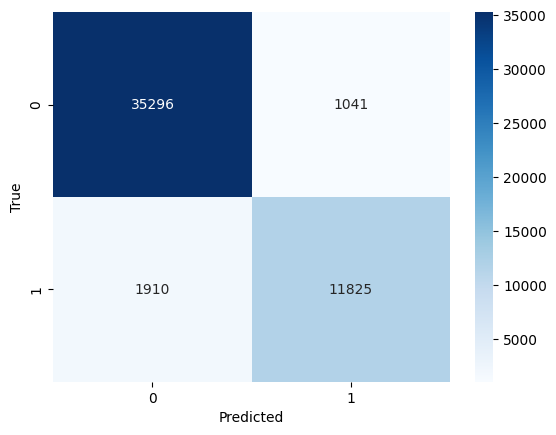

<Figure size 640x480 with 0 Axes>

In [11]:
# Compute the confusion matrix
cnn_cm = confusion_matrix(cnn_y_test,cnn_y_pred)

# Plot the confusion matrix
sns.heatmap(cnn_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save the plot as an image
plt.savefig('cnn_confusion_matrix.png')

### ANN

In [7]:
# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(units=2048, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=1024, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=512, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=256, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=128, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=16, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=1, activation='sigmoid'))

In [8]:
# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

nbepochs=50
batchsize=128

# Train the model
ann_history = ann_model.fit(cnn_X_train, cnn_y_train, epochs=nbepochs, batch_size=batchsize, validation_split=0.15)

# Evaluate the model on the test set
ann_loss, ann_accuracy = ann_model.evaluate(cnn_X_test, cnn_y_test)
print('Loss:', ann_loss)
print('Accuracy:', ann_accuracy)

Epoch 1/50
776/776 [==============================] - 39s 49ms/step - loss: 0.5090 - accuracy: 0.7484 - val_loss: 0.4606 - val_accuracy: 0.7641
Epoch 2/50
776/776 [==============================] - 29s 38ms/step - loss: 0.4524 - accuracy: 0.7849 - val_loss: 0.4369 - val_accuracy: 0.7985
Epoch 3/50
776/776 [==============================] - 29s 38ms/step - loss: 0.4194 - accuracy: 0.8058 - val_loss: 0.3912 - val_accuracy: 0.8197
Epoch 4/50
776/776 [==============================] - 29s 38ms/step - loss: 0.3928 - accuracy: 0.8202 - val_loss: 0.3664 - val_accuracy: 0.8329
Epoch 5/50
776/776 [==============================] - 29s 38ms/step - loss: 0.3682 - accuracy: 0.8331 - val_loss: 0.3437 - val_accuracy: 0.8441
Epoch 6/50
776/776 [==============================] - 29s 38ms/step - loss: 0.3464 - accuracy: 0.8449 - val_loss: 0.3224 - val_accuracy: 0.8561
Epoch 7/50
776/776 [==============================] - 30s 39ms/step - loss: 0.3262 - accuracy: 0.8553 - val_loss: 0.3064 - val_accuracy:

In [9]:
# Predict the labels of the test data
ann_y_pred = ann_model.predict(cnn_X_test)
# Convert the predicted probabilities to class labels
ann_y_pred = pd.Series(np.ravel(ann_y_pred))
ann_y_pred = (ann_y_pred >= 0.5)

# Compute the recall score
ann_report = classification_report(cnn_y_test,ann_y_pred)

print(ann_report)

1565/1565 [==============================] - 10s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     36306
           1       0.94      0.91      0.93     13766

    accuracy                           0.96     50072
   macro avg       0.95      0.95      0.95     50072
weighted avg       0.96      0.96      0.96     50072



In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the metrics
mae = mean_absolute_error(cnn_y_test,ann_y_pred)
rmse = np.sqrt(mean_squared_error(cnn_y_test,ann_y_pred))
train_loss = ann_history.history['loss'][-1]
val_loss = ann_history.history['val_loss'][-1]

print("MAE: ", np.mean(mae))
print("RMSE: ", rmse)
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

MAE:  0.0407013899984023
RMSE:  0.2017458549720472
Training loss:  0.12052968144416809
Validation loss:  0.12198410928249359


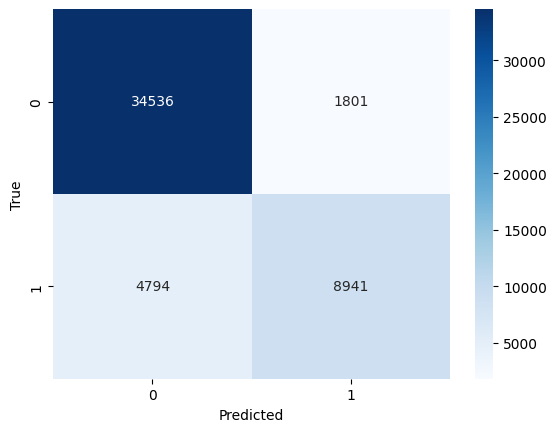

In [16]:
# Compute the confusion matrix
ann_cm = confusion_matrix(cnn_y_test,ann_y_pred)

# Plot the confusion matrix
sns.heatmap(ann_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### XGBoost (for anomaly location)

In [ ]:
xgb = XGBClassifier()
xgb.fit(Row_X_train, Row_y_train)